# 9.1 Camera calibration

In the previous notebooks we have learnt how 3D points are projected to image pixels through the *camera model*, using **a series of parameters** that does not depend on the position of the 3D points, but on the camera itself, such as the focal length $f$, the principal point coordinates $(u_0,v_0)$ or the position of the camera with respect to the `WORLD` reference system. These parameters are categorized in two sets: 
- **intrinsic (or internal)**, and
- **extrinsic (or external)**. 

The first category includes the parameters that are **constant for the same camera** (unless we are using a camera that can change its zoom), while the latter only **depends on the position and orientation of the camera** in the world. In the complete projective equation, they are placed as follows:

$$\lambda \begin{bmatrix} u \\ v\\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} f k_x & 0 & u_0  \\ 0 & f k_y & v_0 \\ 0 & 0 & 1 \end{bmatrix}}_{\text{intrinsic}} \underbrace{\begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix}}_{\text{extrinsic}} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

The process of estimating the intrinsic and/or the extrinsic parameters of a vision system is called **camera calibration**. And that is what we are going to accomplish in this notebook!

The **intrinsic parameters** deal with the camera's internal characteristics, and includes:
- its focal length ($f$), 
- the skew ($k_x, k_y$) parameters, 
- and the image center, a.k.a the coordinates of the principal point ($u_0, v_0$). 

In turn, the **extrinsic parameters** describe:
- its position ($\mathbf{t}$) 
- and its orientation ($\mathbf{R}$) in the `WORLD` reference system.

Apart from this, there is a process we have not talked about yet in the previous notebooks, but which is of capital importance when dealing with generating images: **lens distortion**. We will address this topic in here too.

So, in summary, in this notebook we are going to learn about:
- lens distortion,
- a general procedure for calibration,
- the Direct linear transformation (DLT) calibration method,
- and the Zhang's method for calibration.

## Problem contex - Removing the lens distortion

All cameras have **radial distortion** because using real lens. In the mathematical derivation we presented in the previous notebook, we assumed that no distortion was affecting the image formation procedure and hence the light coming from a certain 3D point travelled **following a straight line**, passing through the optical center and eventually hitting the sensor plane. We could say that the lens in our model was **ideal**. In real life, though, the light gets distorted when passing through the lens and **changes its direction** before reaching to the sensor. This produces distortion in the captured image.

Of course, this distortion is sometimes desired (mostly for aesthetic reasons) but sometimes we need to compensate it in order to get a proper image. A typical example of high radial distortion is present in **action cameras** or **fish-eye cameras**.

<img src="./images/intro.jpg" width="400"/>

As you can see in the image, **straight lines in the world are not straight in the image** due to the distortion. And such distortion is more severe in the pixels further away from the center of the image (hence the term **radial** distortion).

Typically, the distortion degree is given by a pair of variables, which should also be included in the category of intrinsic parameters. The calibration process also has the aim of determining the value of such parameters so that we can eliminate the distortion, even if it is considerably severe.

In this notebook we will compute all the intrinsic parameters of your smartphone's camera, including the distortion ones, and use them to get a proper undistorted picture.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
# from ipywidgets import interact, fixed, widgets
import glob
matplotlib.rcParams['figure.figsize'] = (14.0, 10.0)

images_path = './images/'

## 9.1.1 Lens distortion

Let's start by formally stating the model of the distortion. 



All the cameras distort the image to some extent, including our smartphone's camera, but, obviously, fish-eye cameras and sport cameras have a bigger **radial distortion** because their lens are more convex. The use of more convex lenses is justified in these cases as they have a **wider field-of-view** and, therefore, they can capture a bigger part of the scene. Moreover, the smaller the focal length of camera, the bigger the lens distortion it will suffer!

In any case, we can define the camera distortion by this formula (this is called the *even-order polynomial model*):$\\[10px]$

$$\begin{eqnarray}u_u & = & (1 + k_1 r^2 + k_2 r^4 + \ldots)(u_d-u_0) \qquad (u_d, v_d) \; \; \text{distorted pixels}\\ v_u & = & (1 + k_1 r^2 + k_2 r^4 + \ldots)(v_d-v_0) \qquad (u_u, v_u) \; \; \text{undistorted pixels}\end{eqnarray}\\[25px]$$ $$\text{with}\; r^2 = (u_d-u_0)^2+(v_d-v_0)^2$$

Note that the $r$ value stands for the **distance of the pixel to the center of the image**. In this model, the distortion degree is given by the distortion parameters ($k_1,\ k_2, \ldots$), creating a **non-linear expression of the distortion**, which depending on the sign of $k_1$ can produce two distorted shapes, namely **pincushion and barrel**.$\\[10px]$

<img src="./images/radial.png" width="600"/>

As you can see, straight lines curve in the image due to the distortion.

There exists another type of distortion called **tangential**, but it appears manily due to small **manufacturing defects leading to the lens and the camera sensor not being parallel**. As it is not directly related to the physical properties of lenses, we will not address this kind in this notebook, we will only mention it:$\\[10px]$

<img src="./images/tangential.png" width="600"/>

So, the idea for removing the radial distortion is to **compute the distortion parameters through camera calibration** and, then, having the distorted pixels $(u_d,v_d)$, and the calibration output $(u_0,v_0)$ and $(k_1, k_2, \ldots)$, we can find a solution for the undistorted pixels $(u_u,\ v_u)$!

There is an alternative to the **polynomial model** presented above called the **division model**, which is preferred because it requires fewer terms than the polynomial model in case of severe distortion. It is also slightly easier to work with:

$$u_u = u_0 + \frac{u_d - u_0}{1 + k_1 r^2 + k_2 r^4 + \ldots } \qquad v_u = v_0 + \frac{v_d - v_0}{1 + k_1 r^2 + k_2 r^4 + \ldots }$$

Finally, note that the **number of distortion parameters should be more than only two**, but in general the parameters related to higher orders of the radial distance are small enough to not induce a strong impact in the process of removing distortion, unless we are working in applications that need extremely precise undistorted images.

### **<span style="color:green"><b><i>ASSIGNMENT 1: Experiencing the division model</i></b></span>**

Imagine we are using a sport camera with a severe radial distortion and the intrinsic parameters are provided in the camera's documentation. **Compute the undistorted coordinates** for the pixels $(0,0)$, $(200,200)$ and $(400,400)$ **using the division model**, knowing that the intrinsic parameters of this camera are: 

- $k_1 = -2.98786806·10^{-06}$, 
- $k_2 = 4.90775450·10^{-13}$, and
- $(u_0,v_0) = (303, 244)$.

In [2]:
# ASSIGNMENT 1
# Exercise data
k1, k2 = -2.98786806E-6,  4.90775450E-13
u0, v0 = 303, 244

# Write your code here!
distorted = np.array([[0, 200, 400],
                      [0, 200, 400]], dtype=np.float64)

# Define auxiliar matrices
undistorted = np.zeros_like(distorted)
r = (distorted[0,:] - u0)**2 + (distorted[1,:] - v0)**2
dr = 1 + k1*r + k2*(r**2)


# Compute undistorted pixels
undistorted[0,:] = u0 + ( (distorted[0,:] - u0)/dr)
undistorted[1,:] = v0 + ( (distorted[1,:] - v0)/dr)

print(np.round(undistorted,1))

[[-239.   196.   410.8]
 [-192.5  198.3  417.4]]


**Now, check your results**

<font color='blue'>**Expected output:**  </font>

     [[-239.   196.   410.8]
     [-192.5  198.3  417.4]]

## 9.1.2 Camera calibration

The process of camera calibration implies determining a certain matrix $\mathbf{P}_{3\times4}$, which allows to compute the projection $\bf{m}' = [u\ v]^\texttt{T}$ on the image (in pixels) of any world point $\bf{M} = [X\ Y\ Z]^\texttt{T}$ in space:

$$\lambda\bf{\tilde{m}'}= \begin{bmatrix} \lambda u \\ \lambda v \\ \lambda \end{bmatrix} = \bf{P\tilde{M}} = \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \\[30pt]$$

$$u= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \qquad \qquad v= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}$$

If you recall from the last notebook, this matrix includes both the calibration matrix $\mathbf{K}$ and the homogeneous transformation between the `CAMERA` and the `WORLD` reference systems:

$$\bf{P = K[R\ t]}\\[10pt]$$

But we want to **explicitly compute** these two elements separately, that is:

- the **camera pose** $(\mathbf{R}, \mathbf{t})$, which includes **6 extrinsic parameters** ($t_x,\ t_y,\ t_z,\ \text{yaw},\ \text{pitch},\ \text{roll}$):$\\[5pt]$

$$\bf{[R\ t]} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x\\ r_{21} & r_{22} & r_{23} & t_y\\ r_{31} & r_{32} & r_{33} & t_z \end{bmatrix}\\[10pt]$$

- the **camera intrinsic parameters** ($f,\ k_x,\ k_y,\ u_0,\ v_0$):$\\[5pt]$

$$K = \begin{bmatrix} fk_x & 0 & u_0\\ 0 & fk_y & v_0 \\ 0 & 0 & 1 \end{bmatrix}\\[10pt]$$

Aditionally, we want to determine **two radial distortion parameters** ($k_1, \ k_2$):$\\[5pt]$

$$\begin{eqnarray}u_d = (1 + k_1 r^2 + k_2 r^4)u_u\\ v_d = (1 + k_1 r^2 + k_2 r^4)v_u\end{eqnarray}$$

However, as $(\mathbf{R}, \mathbf{t})$ change as the camera moves, camera calibration generally refers to computing the matrix $\mathbf{K}$, and the distortion parameters $(k_1,k_2)$.

### General procedure for calibration

**Step 1. Get a set of known 3D points** $\mathbf{M}_i$ (the more the better):

To get a set of 3D points $\mathbf{M}_i$, a **calibration pattern** is employed. This pattern should be easily identificable on the image (typically a chessboard is employed), and the 3D points must not be in a single plane (several planes are needed).$\\[8pt]$

<img src="./images/pattern.png" width="600"/>$\\[5pt]$

**Step 2. Provide their projections on the image** $\mathbf{m}_i$ (in pixels):

For this, we first detect the corners of the squares in the pattern (e.g. using the Harris detector). Then, we set the pairs ($\mathbf{M}_i,\ \mathbf{m}_i$) based on the 2D ordered list of corners detected (the number of columns and rows of the patterns is known beforehand).$\\[8pt]$

<img src="./images/2dPattern.png" width="300"/>$\\[5pt]$

**Step 3. Apply the camera model to estimate the parameters** $\mathbf{K},\ \mathbf{R},\ \mathbf{t}$ that best solve for the matches between the corresponding pairs ($\mathbf{M}_i,\ \mathbf{m}_i$)

This is the more complex step and there exist many alternatives, some of them very popular. In this notebook we are going to address two of them:

- The Direct Linear Transformation (DLT)
- The Zang's method

## 9.1.3 The DLT calibration method

It computes $\bf{K,\ R,}$ and $\bf{t}$ directly from $\bf{P}$ and **does not take into account the distortion** (it is assumed to be negligible). 

For that, first, the matrix $\bf{P}$ is computed from a set of $N \ge 6$ points, as $\bf{P}$ has 11 d.o.f. This is accomplished similarly to the homography computation in previous notebooks.

$$\bf{P} = \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix}$$

Then, given that $\\[5pt]$

$$\bf{P = K\ [R\; t] = [KR\; Kt] = [B\; b]}\\[5pt]$$

we use its $3 \times 3$ left submatrix $\bf{B}$ to compute the rotation matrix and the calibration matrix, and the right column vector $\bf{b}$ to compute the translation as follows:

 1. Perform **RQ-factorization** to decompose $\bf{B}$ in the product of two matrices: $\bf{B = RQ}$, where $\bf{R}$ is an upper triangular matrix (corresponding to the calibration part, i.e. $\bf{K}$) and $\bf{Q}$ is an orthogonal matrix (corresponding to the rotation matrix). $\\[10pt]$
    
$$\bf{B}  = \begin{bmatrix} p_{11} & p_{12} & p_{13} \\ p_{21} & p_{22} & p_{23} \\ p_{31} & p_{32} & p_{33} \end{bmatrix} = KR = \underbrace{\begin{bmatrix} k_{11} & k_{12} & k_{13} \\ 0 & k_{22} & k_{23} \\ 0 & 0 & k_{33} \end{bmatrix}}_{\text{intrinsic}}\underbrace{\begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & r_{33} \end{bmatrix}}_{\text{extrinsic (rotation)}}$$
    
The solution to this system is not unique (there exist different combinations of signs), but we can choose the correct one by forcing the diagonal elements of $\bf{R} (=\bf{K})$ to be all positive. From the rotation matrix, the parameters $yaw$, $pitch$ and $roll$ can be easily determined.

*Note: RQ-factorization is analogous to the widely known [QR-decomposition](https://en.wikipedia.org/wiki/QR_decomposition) procedure but changing the order of the matrices.*

2. Given $\bf{K}$ and $\bf{b}$, we can obtain the translation part from $\bf{b = Kt}$   $\rightarrow$ $\bf{t = K^{-1}b}$ 
 
 $$\bf{b} = \underbrace{\begin{bmatrix} p_{14} \\ p_{24} \\ p_{34} \end{bmatrix}}_{\text{known}} = \bf{Kt} =  \underbrace{\begin{bmatrix} k_{11} & k_{12} & k_{13} \\ 0 & k_{22} & k_{23} \\ 0 & 0 & k_{33} \end{bmatrix}}_{\text{known}} \underbrace{\begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix}}_{\text{unknown}}$$
 

 ## 9.1.4 The Zhang's method
 
All in all, the DLT method is not used quite often but, instead, the Zhang's method is applied, mostly because it is more friendly to use.  
 
In the Zhang's method the **calibration pattern is just a simple picture of a checkerboard** (e.g. printed on a paper), so you do not need to build a structure with several planes, as it is **based on 2D homographies** between the template and their images. In order to capture the images, either the camera or the pattern can be moved. Here you can see some examples of the kind of images used for the calibration.$\\[5pt]$
 
<img src="./images/zhangs.png" width="400"/>$\\[5pt]$
 
**Procedure:**

- **Print the pattern template** and fix it to a rigid planar surface (e.g. a cardboard or a wooden board)$\\[4pt]$

- **Take several images of the pattern** at different poses, either moving the camera or the pattern so that the pattern is seen at different positions in the image and with different angles.$\\[4pt]$

- **Detect the corners** of the squares in the images.$\\[4pt]$

- **Estimate** the 5 intrinsic and 6 extrinsic parameters through a **closed form solution**, as we will show next. This solution is not very accurate and it does not include the radial distortion.$\\[4pt]$

- **Refine** the previous solution and find a more precise value for $\bf{K,\ R,\ t}$ and $k_1, k_2$ by **iteratively solving a non-linear system** (here we include the distortion)$\\[4pt]$
 
### Parameter rough estimation
We first use a closed-form solution to estimate these linear parameters (not the distortion!):
- The calibration matrix $\bf{K}$, where we have turned $(fk_x,fk_y)$ into just 2 unknows $(s_x,s_y)$, so that we have a total amount of **4 unknowns**: $(u_0,v_0,s_x,s_y)$
- The rotation and translation $\bf{R}_i$ and $\bf{t}_i$, with $i=\{1,\ldots,N\}$, being $N$ the number of images taken and **leading to $6N$ unknowns**.

Roughly speaking, the procedure is as follows (the details can be found in the [original paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf)):
1. Estimate the homography $\bf{H_i}$ for each pair image/plane-pattern.$\\[4pt]$

2. Compute the calibration matrix $\bf{K}$ from the set of $\bf{H_i}$.$\\[4pt]$

3. Compute $\bf{R}_i$, $\bf{t}_i$ for each plane pattern from the calibration matrix and each homography $\bf{H_i}$.$\\[4pt]$

However, the result of this method is **not precise enough** since:

- The computed $\bf{R}_i$ are not orthogonal matrices.$\\[4pt]$
- No radial distortion has been considered.$\\[4pt]$

### Refinement step
In order to get a better solution, we can **either iterate the closed-form approach**, incorporating a solution for the lens distortion equations and check for errors in the point projection, **or solve for all the parameters** $(\bf{R}_i$, $\bf{t}_i)$ and the distortion ($k_1,k_2$) following an iterative Levemberg-Marquadt-based approach and using as initial solution that yielded by the closed-form procedure. The aim is also to minimize the reprojection error:$\\[4pt]$

$$error = \sum_{i=1}^n\sum_{j=1}^m\; ||{\bf{m}_{ij} - \tilde{\bf{m}}\ (\bf{K},\ \bf{R}_i, \bf{t}_i, k_1, k_2, \bf{M}_j)}||^2$$

### How many images of the pattern do we need?

In this method, if we have $N$ images with $M$ corners each, we have $2NM$ equations, and, as we said before, we need to estimate 4 intrinsic parameters ($fk_x,\ fk_y,\ u_0,\ v_0$) for the calibration matrix and a total of $6N$ extrinsic parameters ($\bf{R}_i,\ \bf{t}_i$), with $i=\{1,\ldots,N\}$.

$$2NM \ge 4 + 6N \Longrightarrow N \ge \frac{2}{M-3}\; \text{and}\; M\gt 3$$

So, we need at least:

- $N=2$ images with $M=4$ points each, but this solution has low precision due to the noise in the points. As always, the more number of employed images the better! Apart from that, it is important that the pattern is captured in the most varied positions in the image, in order to avoid overfitting of the parameters to one zone of the image.

*Note that this situation would also be numerically valid*: 
- *$N = 1$ images with $M = 5$ points $\rightarrow 2NM = 10$ equations and $4+6N = 10$ unknowns, but **this is not really a solution, since all the points would be coplanar**, and that would be an **ill-conditioned** problem!*

## 9.1.5 Coding

Now that you know how camera calibration works, we are going to use **OpenCV for calibrating our smartphone camera** (or the example images provided in `/images/calibration` if you don't have one). When we calibrate a camera, the distortion parameters of the camera are also determined. With them, it is possible to remove the radial distortion of camera images (usually for smartphone cameras is unnoticeable, unless for those with wide-angle lens, but you could also use a sport camera if you are lucky enough to have one).

Fortunately for us **OpenCV already defines a calibration method** [cv2.calibrateCamera()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d), which implements a **variant of the Zhang's method**. But first, as explained above, we need a **calibration pattern** with the picture of the checkerboard. In the classroom it will be provided to you but you can always print [one](https://www.google.com/search?q=camera+calibration+pattern&tbm=isch&ved=2ahUKEwi56NbFsqTpAhWO1uAKHXlVAIAQ2-cCegQIABAA&oq=camera+calibration+pattern&gs_lcp=CgNpbWcQAzICCAAyBggAEAgQHjIGCAAQCBAeMgQIABAYOgQIIxAnOgQIABBDUMIyWMdTYP5UaAJwAHgAgAFbiAGuEJIBAjI4mAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=nGG1XrmqPI6tgwf5qoGACA&bih=951&biw=1853&client=ubuntu&hs=qxl&hl=en) for calibrating your camera at home.

Let's start!

1. Move either the calibration pattern or the camera to capture a set of **several images of the pattern** from different perspectives.

2. Then, we will have to **detect the corners** (e.g. using the Harris corner detector) of all images. Fortunately, OpenCV defines a optimized method [cv2.findChessboardCorners()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a), which automatically detects the corners of the pattern. 

3. These corners will **have to be matched with the pixels coordinates without perspective** for calculating the homographies (remember when you matched the points of the football field to the corners of a rectangle?). As an example, if we detect the second corner of the third column in the pattern, we will have to match the pixel detected by `cv2.findChessboardCorners()` with a multiple of $(1,2)$. 

4. Provide the **mapping of the corners** of the pattern images as the input of the `cv2.calibrateCamera()` method, which **directly returns the intrinsic parameters and the radial and tangential distortion parameters!**.

5. **Once we have the intrinsic parameters** we will call the [cv2.undistort()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) method, which implements an **iterative algorithm** to remove the distortion of the image by calculating the normalized original point coordinates from the normalized distorted point coordinates (*normalized* means that the coordinates do not depend on the camera matrix). 

**Well, let's give it a go, but step by step!**

### **<span style="color:green"><b><i>ASSIGNMENT 2: Defining the ideal pattern image</i></b></span>**

First, we are going to **define the matrix containing the object points**, which is a matrix with shape $(\text{#corners},3)$. This matrix contains the ideal coordinates of the corners in a non-perspective image of the pattern (necessary for obtaining the homographies). **This will be our ideal image of the pattern**.

As the corners will be detected using `cv2.findChessboardCorners()`, the order of the corners is fixed, and should be like this:

$$[(0,0,0),\ (1,0,0),\ (2,0,0),\ \ldots ,\ (\text{n_rows}, \text{n_cols},0)]$$

Take into account that the corners we will detect are the **inner corners of the pattern**. [`np.mgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html) can help you here.

So, our first task is to build a matrix like this (the third column is mandatory):

<font color='blue'>**Expected output (for a $12\times13$ corners pattern, adapt these numbers to your own pattern):**  </font>

    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     [ 2.  0.  0.]
     [ 3.  0.  0.]
           .
           .
           .
     [ 8. 12.  0.]
     [ 9. 12.  0.]
     [10. 12.  0.]
     [11. 12.  0.]]

In [9]:
# ASSIGNMENT 2
# Write your code here!
# Pattern corners
# corners_r = 12
# corners_c = 13

corners_r = 6
corners_c = 9

# Prepare object points matrix
objp = np.zeros((corners_r*corners_c,3), dtype= np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

# Print object points matrix
print(objp)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [0. 7. 0.]
 [1. 7. 0.]
 [2. 7. 0.]
 [3. 7. 0.]
 [4. 7. 0.]
 [5. 7. 0.]
 [0. 8. 0.]
 [1. 8. 0.]
 [2. 8. 0.]
 [3. 8. 0.]
 [4. 8. 0.]
 [5. 8. 0.]]


### **<span style="color:green"><b><i>ASSIGNMENT 3: Detecting corners</i></b></span>**

Now, we will **detect the corners of all the images** contained in `./images/calibration/` using the `findChessboardCorners` method, which takes a grayscale image as input as well as the number of rows and columns of corners that our pattern has. It returns a boolean value, which indicates whether the pattern was found in the image or not. 

*Note: if you use your own pictures, **do not compress them**, as it happens, for instance, when they are shared via WhatsApp*.

If the corners are found correctly, we will establish a map between the detected coordinates and the ideal ones, as that is the input that the `cv2.calibrateCamera()` method takes. Besides, if you want to check if the corners have been detected in a correct way, you can draw them on the image using [drawChessboardCorners()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022) and, then, show the image.

So, in summary, this is what you need to do:
- **define two lists**, one for storing the detected corners and the other one for storing the "ideal" coordinates of the points in the pattern (i.e. that matrix you created in the assignment 2a).
- for each image, **try to find the corners** of the checkerboard using `findChessboardCorners` and, if the result is valid, add it to the first list. Note that this process will not be always succesfull because the pattern might not be clearly visible!, hence checking the result of the method.
- add a copy of the **ideal corners matrix** you created before to the second list. This way we have a duple "detected points" $\rightarrow$ "ideal points" for the homography computation for each image where the pattern has correctly been detected.

Number of images:  9
Processing: ./images/cal3\02 (1).jpg [OK]
Processing: ./images/cal3\02 (2).jpg [OK]
Processing: ./images/cal3\02 (3).jpg [OK]
Processing: ./images/cal3\02 (4).jpg [OK]
Processing: ./images/cal3\02 (5).jpg [OK]
Processing: ./images/cal3\02 (6).jpg [OK]
Processing: ./images/cal3\02 (7).jpg [OK]
Processing: ./images/cal3\02 (8).jpg [OK]
Processing: ./images/cal3\02 (9).jpg [OK]
Number of patterns found: 9


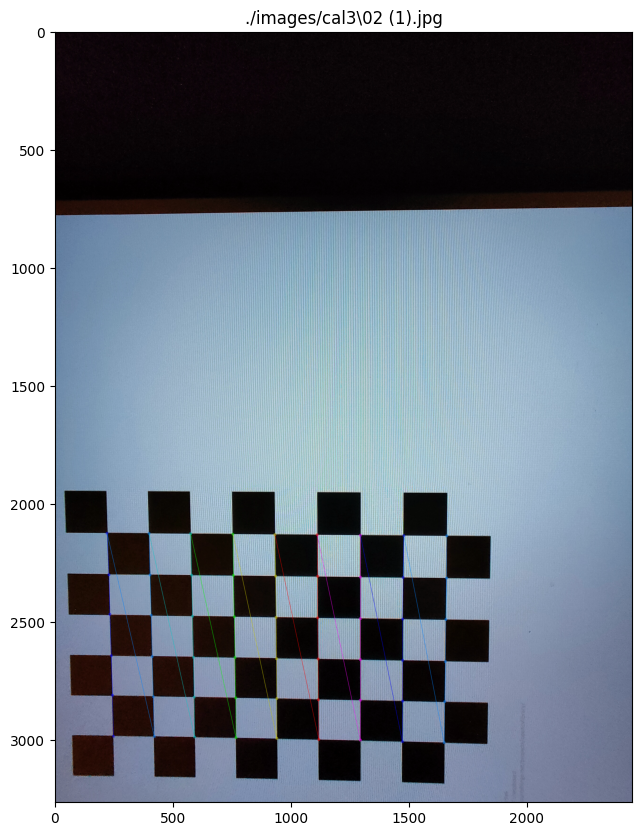

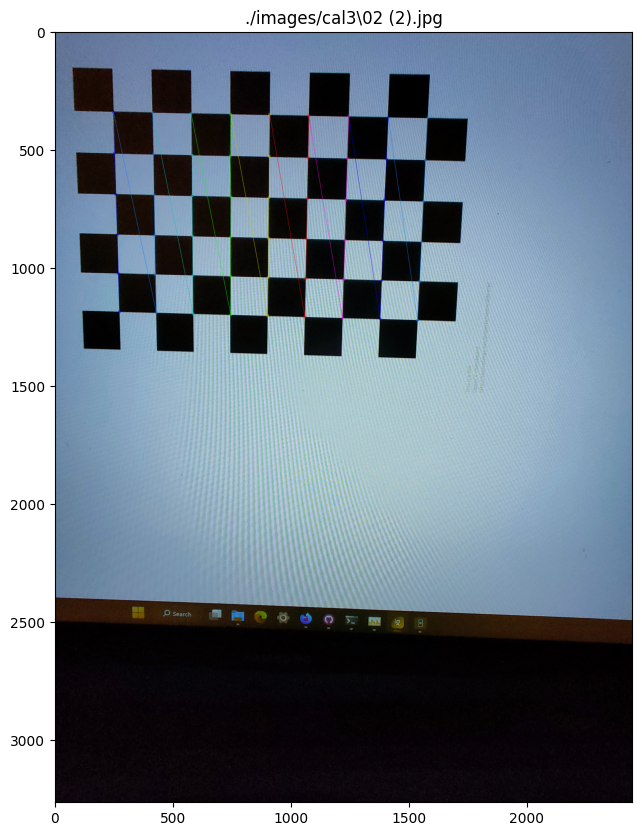

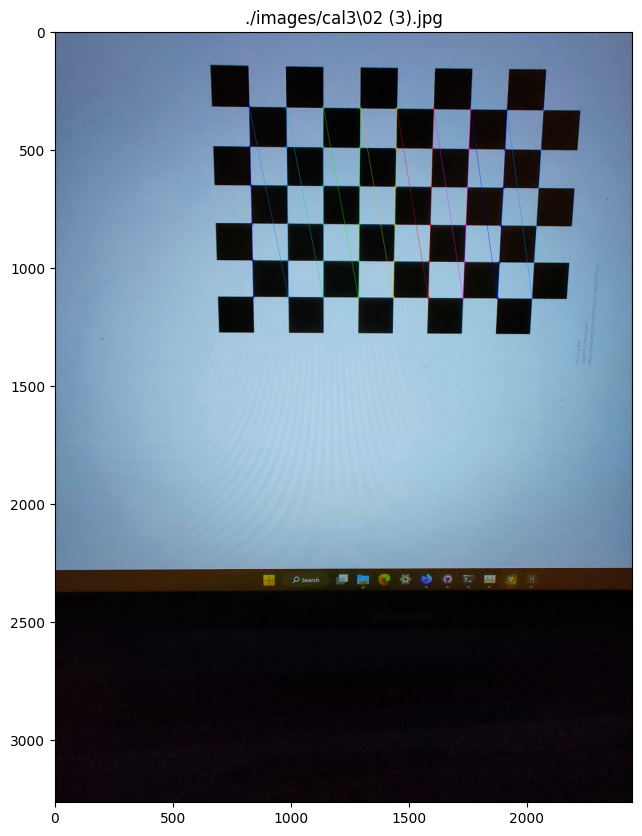

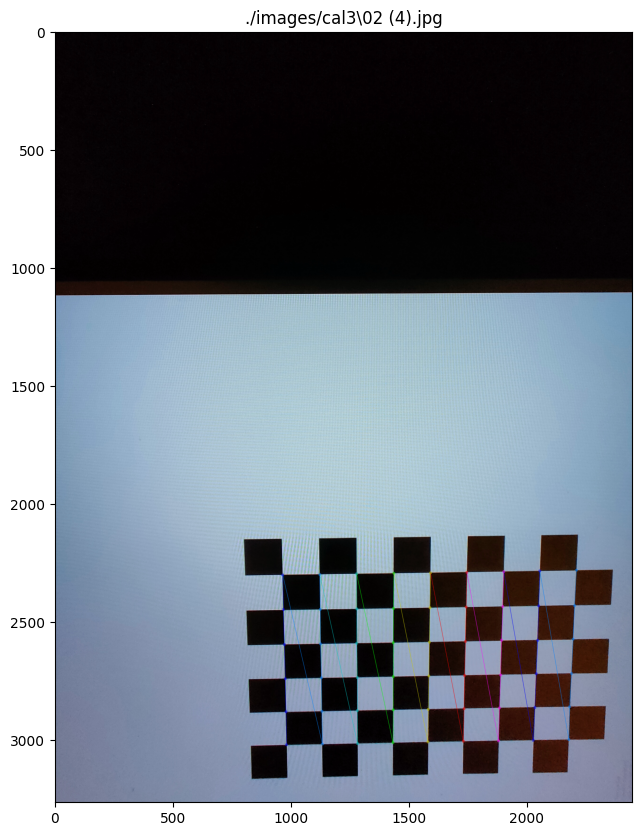

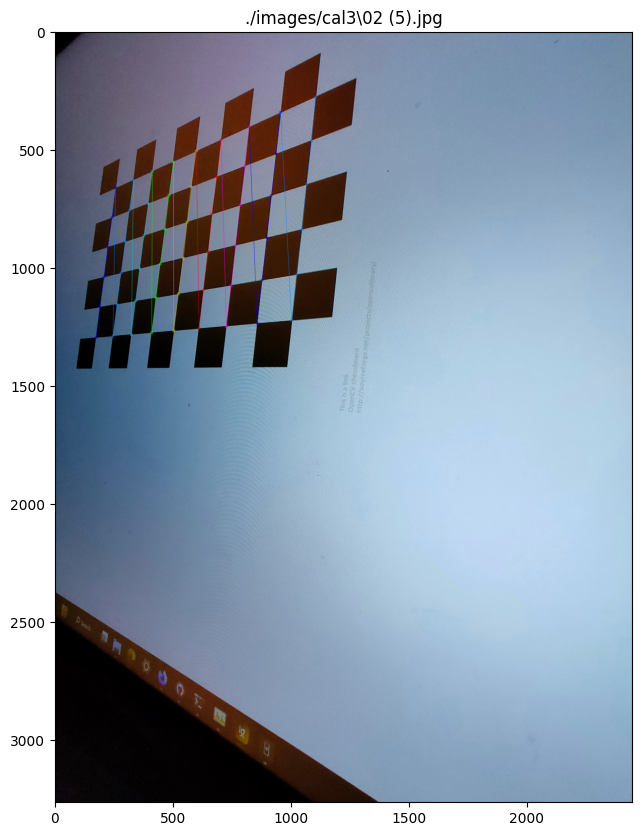

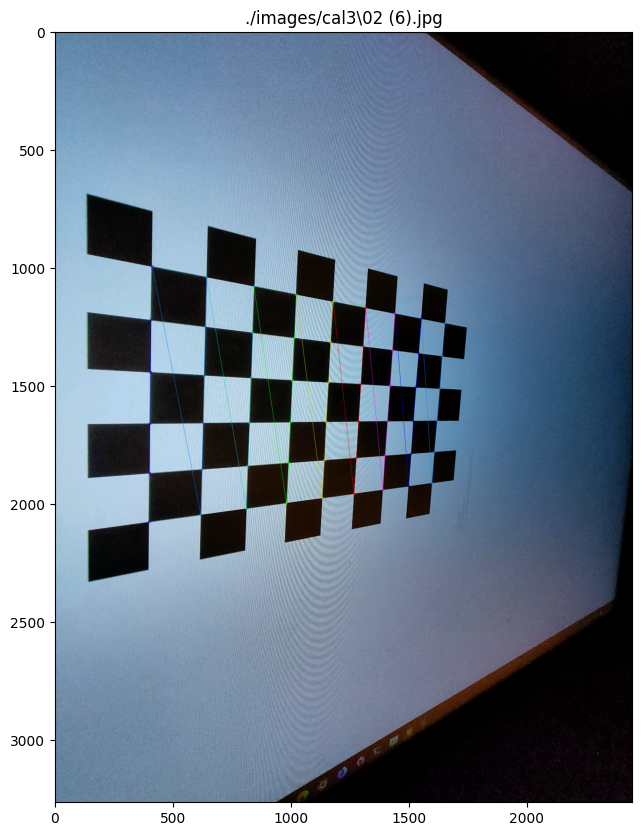

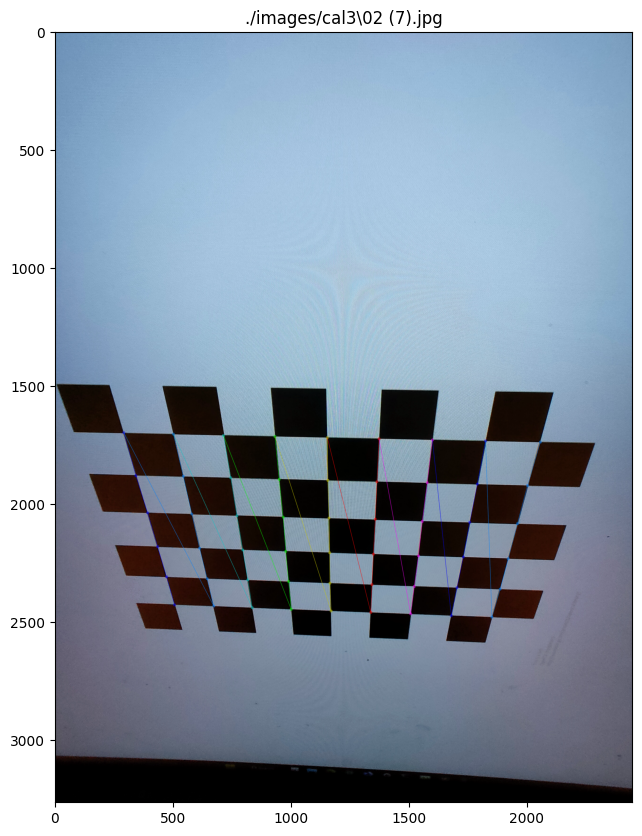

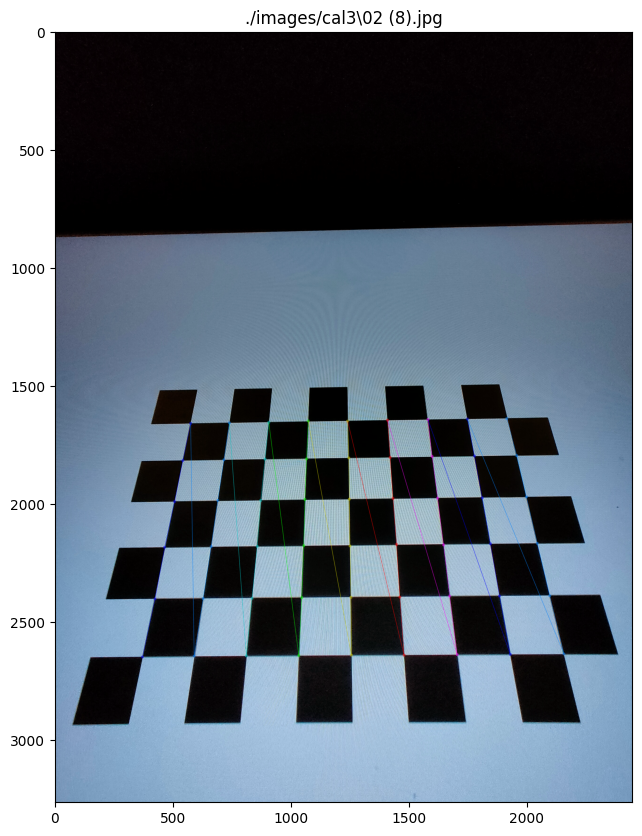

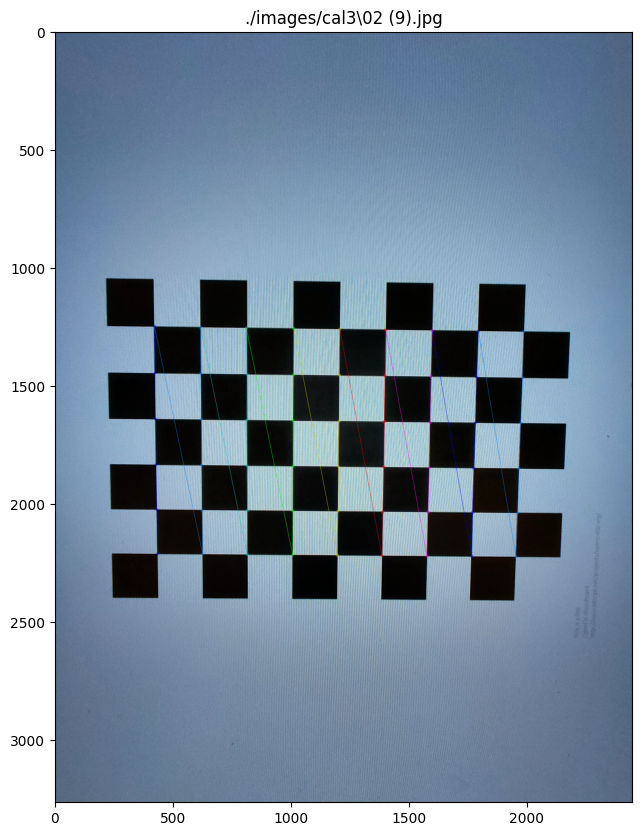

In [10]:
matplotlib.rcParams['figure.figsize'] = (14.0, 10.0)

# ASSIGNMENT 2b
# Write your code here!
# Read images names
# images = glob.glob(images_path + '/calibration_01/*.tif')
# images = glob.glob(images_path + 'calibration_02/small*.jpg')
images = glob.glob(images_path + 'cal3/*.jpg')
print("Number of images: ",len(images))

# Define lists for storing both the object points and the corresponding image points
objpoints = []
imgpoints = []

# Find corners in each pattern
for file in images:
    print("Processing:", file, end=' ')
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6,9))
    
    # If corners are found, match object points with image corners
    if ret == True:
        print("[OK]")
        
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # show the first image with corners detected
        cv2.drawChessboardCorners(img, (6,9), corners, ret)
        plt.figure()
        plt.title(file)
        plt.imshow(img)
        
    else:
        print("[NOK]")

print("Number of patterns found:", len(objpoints))

In [11]:
print("Number of points found:", imgpoints[0].shape[0])
print("Image size:", gray.shape)

Number of points found: 54
Image size: (3264, 2448)


### **<span style="color:green"><b><i>ASSIGNMENT 4: Calibrating the camera</i></b></span>**

Now, we will use both lists obtained in above exercise for the [cv2.calibrateCamera()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) method, which **returns the intrinsic, extrinsic and distortion parameters** of the camera, as well as the rotation and translation parameters for all the views! This method also takes as input the size of the images (used only to initialize the intrinsic camera matrix).

In [12]:
# ASSIGNMENT 2c
# Write your code here!
# Apply Zang's method for calibrate the camera
h,w,_ = img.shape
_, intrinsic, distortion, rotation, translation = cv2.calibrateCamera(objpoints, imgpoints,(h,w), None, None)

print("Intrinsic parameters:")
print(intrinsic)

print("Distortion parameters:")
print(distortion)

tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rotation[i], translation[i], intrinsic, distortion)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)    
    tot_error += error

print ("Mean error: ", tot_error/len(objpoints))

Intrinsic parameters:
[[1.56707060e+03 0.00000000e+00 1.22251547e+03]
 [0.00000000e+00 1.56644411e+03 1.63063650e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion parameters:
[[-0.00614013  0.00206099  0.00059813  0.00042551  0.00176428]]
Mean error:  0.1820001443365705


### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- what **type of radial distortion** has the employed camera?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>We can see that the first k term is a negative number, the the distortion type is barrel</i></p>
    
- Identify your **camera intrinsic parameters** in the camera matrix.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>We can see that the focal lenght times the skey is equal to 1567.07060 ($fk_x$) in x coordinate and very similar parameter 1566.44411 ($fk_y$) on the y coordinate. The image center is ($u_0, v_0$) = (1222.51547, 1630.63650)</i></p>
    
- What does the "mean error" means?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Funcion projectPoints() make projection of the calculated points into a plane. The second function norm() calculating the absolute difference between actual point and projected one. Hense we getting the error for each point. After summing up all errors and dividing by numbers of points we obtaining the mean error.$\newline$ Resuming: we calculating how precisely we calibrate the camera.</i></p>

### **<span style="color:green"><b><i>ASSIGNMENT 5: Undistorting images</i></b></span>**

Finally, now that we have the camera matrix and the distortion parameters, we are going to use [cv2.undistort()](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) to remove the image distortion. This method takes the image as input as well as the camera matrix and the distortion parameters. Then, it **removes both the tangential and radial distortions** of the image and returns it.

**Display both the original and the undistorted image**. 

*Note that if the distortion is low, the change might be unnoticeable.*

True

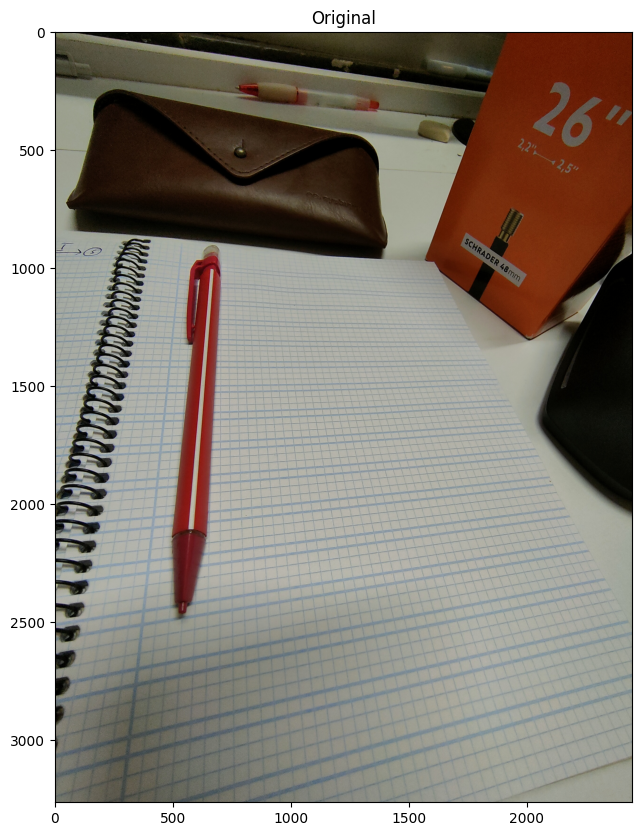

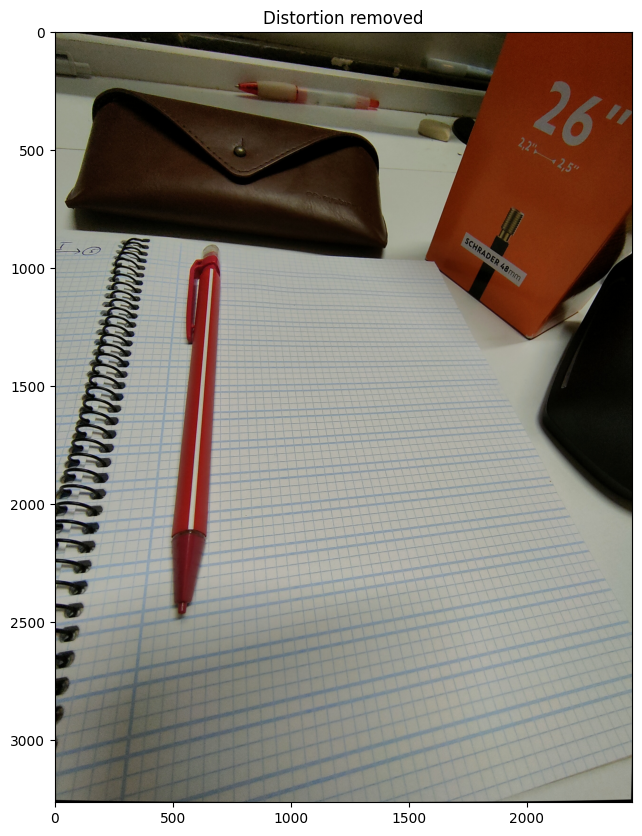

In [14]:
# ASSIGNMENT 2d
# Write your code here!
# Read the image
img = cv2.imread(images_path + 'pen.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort the image
dst = cv2.undistort(img, intrinsic, distortion, None) # Leave the last None as it is!

# Show the original and the undistorted
plt.figure()
plt.title("Original")
plt.imshow(img)

plt.figure()
plt.title("Distortion removed")
plt.imshow(dst);
cv2.imwrite(images_path + 'pen_undist.jpg', cv2.cvtColor(dst, cv2.COLOR_RGB2BGR))

## Conclusion

Great work! You better save the intrinsic values of your camera because you will need them for the next chapter!

In this notebook, you have learnt:

- different types of distortions and how to remove them,
- how to calibrate any camera, using the OpenCV's implementation of the Zhang's method,
- how the DLT calibration method works.
